In [43]:
# Math
import numpy as np
from scipy.stats import multivariate_normal

# Visualization
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

plt.style.use('qualitative.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

class_colors = [colors[1], colors[0], colors[4]]

In [44]:
def get_gaussians(same_covar=False):
    mu_1 = np.array([-10, 0])
    mu_2 = np.array([20, 8])

    c_1 = np.array([[3, 2.5], [2.5, 3]])*100
    if same_covar:
        c_2 = c_1
    else:
        c_2 = np.array([[3, -1.2], [-1.2, 2]])*100

    return get_gaussian_distributions([mu_1, mu_2], [c_1, c_2])


def get_gaussian_distributions(mus, covars):
    return [multivariate_normal(mean=mu, cov=cov) for mu, cov in zip(mus, covars)]


def get_gt_probabilities(x, distributions):
    lpexp = [distrib.pdf(x) for distrib in distributions]
    sm = sum(lpexp)
    return [float(_/sm) for _ in lpexp]


def prepare_dataset(N: int = 100, same_covar = False):
    """
    Prepares the training dataset. Returns Class x N samples, N samples of each class.

    Args:
        N (int, optional): Number of samples per class.

    Returns:
        X: TensorType["batch", "Class*N"]; data
        y: TensorType["Class*N"]; labels
    """
    distributions = get_gaussians(same_covar=same_covar)
        
    samples = [distribution.rvs(N) for distribution in distributions]
    labels = [np.array([i]*int(N)) for i in range(len(distributions))]

    X = np.concatenate(samples)
    y = np.concatenate(labels)
    return X, y, distributions


def visualize_gaussian(distribution,
                       N: int = 200,
                       xmin: float = -20,
                       xmax: float = 20,
                       ymin: float = -20,
                       ymax: float = 25,
                       color='k',
                       levels=None):
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    Z = distribution.pdf(pos)
    ix = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    plt.contour(X, Y, Z, levels=levels, colors=color, cmap=None, alpha=0.5, linewidths=2)


def visualize_decision_boundary(func,
                                axis,
                                N: int = 1000,
                                xmin: float = -20,
                                xmax: float = 20,
                                ymin: float = -20,
                                ymax: float = 25,
                                levels=None):
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    Z = func(np.c_[X.ravel(), Y.ravel()])
    Z = Z.reshape(X.shape)
    axis.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(
        [class_colors[0], class_colors[1]]), alpha=0.2, linewidths=0)


def visualize_decision_boundaries(clf,
                                  N: int = 1000,
                                  xmin: float = -20,
                                  xmax: float = 20,
                                  ymin: float = -20,
                                  ymax: float = 25,
                                  levels=None):
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    Z = clf.predict_proba(np.c_[X.ravel(), Y.ravel()])[:, 0]
    Z = Z.reshape(X.shape)
    plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2, linewidths=2)


def visualize_optimal_decision_boundary(distributions,
                                        N: int = 1000,
                                        xmin: float = -20,
                                        xmax: float = 20,
                                        ymin: float = -20,
                                        ymax: float = 25):
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    Zs = [distribution.pdf(pos) for distribution in distributions]
    Z = np.array([np.argmax(values)
                 for values in zip(*[_.flatten() for _ in Zs])])
    Z = Z.reshape(X.shape)
    plt.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(
        [class_colors[0], class_colors[1]]), alpha=0.2)

# Recap: What is a multivariate Gaussian?

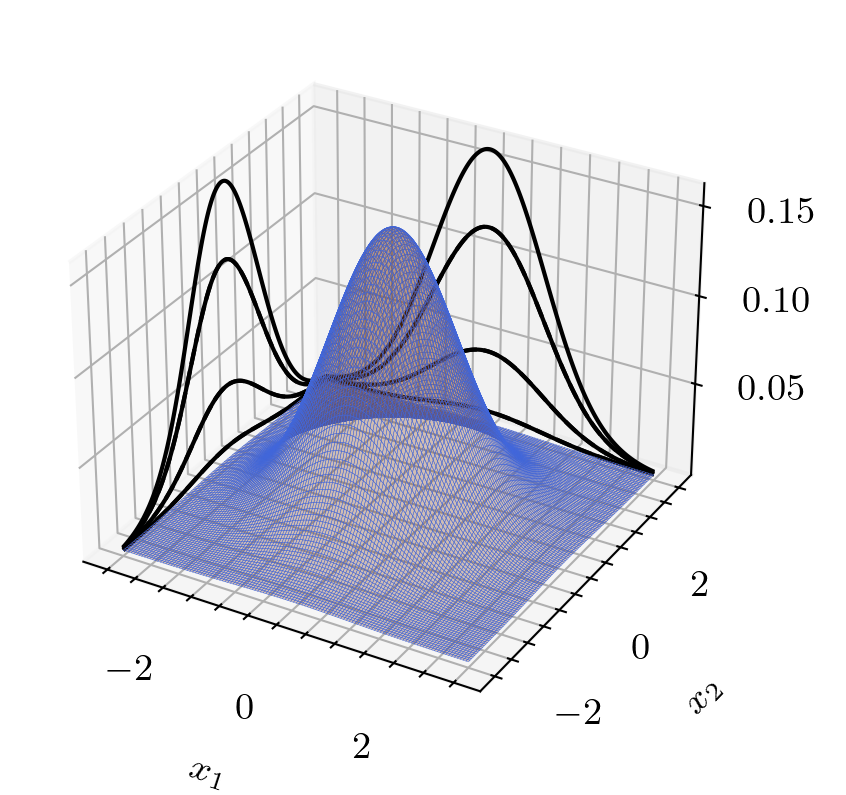

In [45]:
from mpl_toolkits.mplot3d import axes3d


#Create grid and multivariate normal
x = np.linspace(-3,3,1000)
y = np.linspace(-3,3,1000)
Y, X = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
Z = rv.pdf(pos)

#Make a 3D plot
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.1, rstride=8, cstride=8, alpha=0.3)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('p.d.f.')

ax.contour(X, Y, Z, zdir='z', offset=-100, colors='k')
ax.contour(X, Y, Z, zdir='x', offset=-3, colors='k')
ax.contour(X, Y, Z, zdir='y', offset=3, colors='k')


plt.tight_layout()


plt.show()

# Identical Covariance Matrices

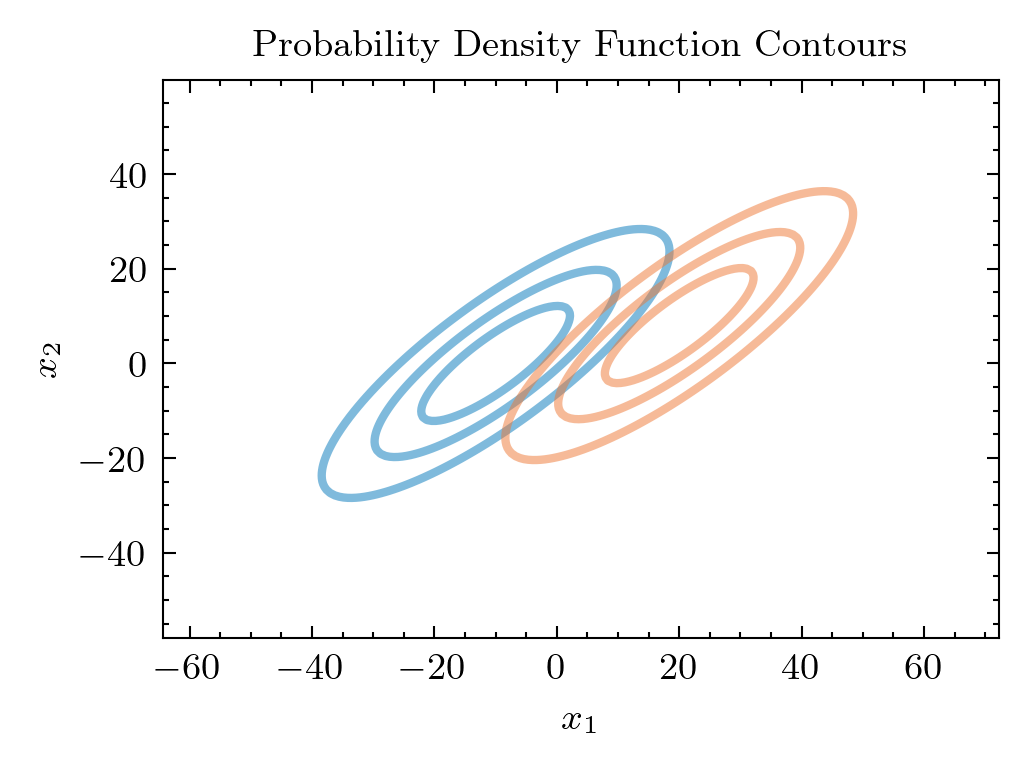

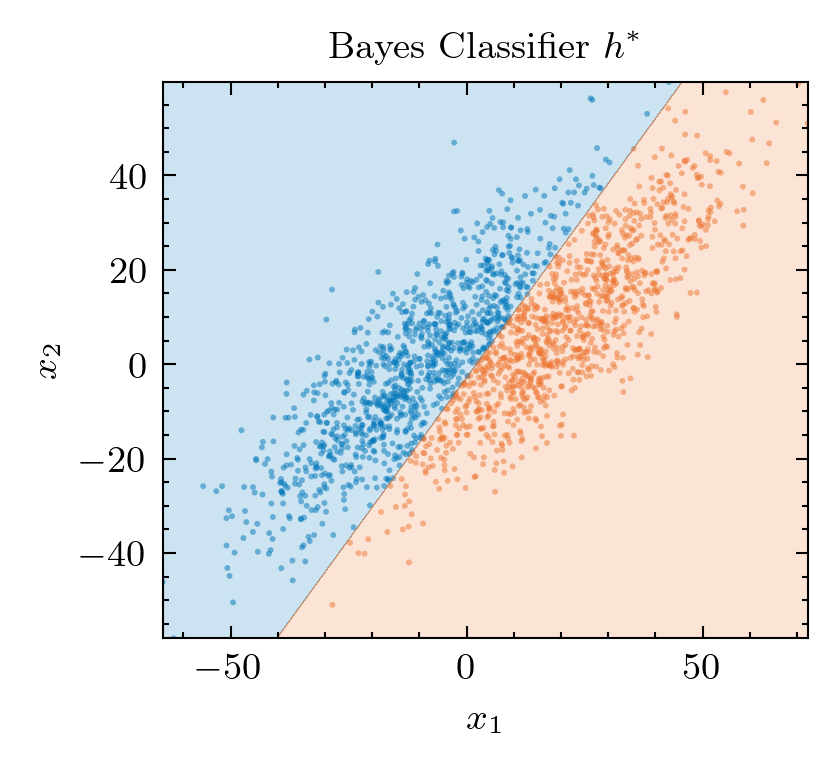

In [46]:
np.random.seed(1)
X, y, distributions = prepare_dataset(N=1000, same_covar=True)

Xmin = np.min(X[:,0])
Xmax = np.max(X[:,0])
Ymin = np.min(X[:,1])
Ymax = np.max(X[:,1])

for distribution, color in zip(distributions, class_colors):
    visualize_gaussian(distribution=distribution, color=color, levels=3, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax)
plt.title("Probability Density Function Contours")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

gt_probs = [get_gt_probabilities(x, distributions=distributions) for x in X]
y_pred = np.array([np.argmax(probs) for probs in gt_probs])
cs = [class_colors[pred] for pred in y_pred]

plt.scatter(X[:,0], X[:,1], s=2, c=cs, alpha=0.5, linewidths=0)

visualize_optimal_decision_boundary(distributions=distributions, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Bayes Classifier $h^*$")
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Tranforming the covariance matrix to an Identity

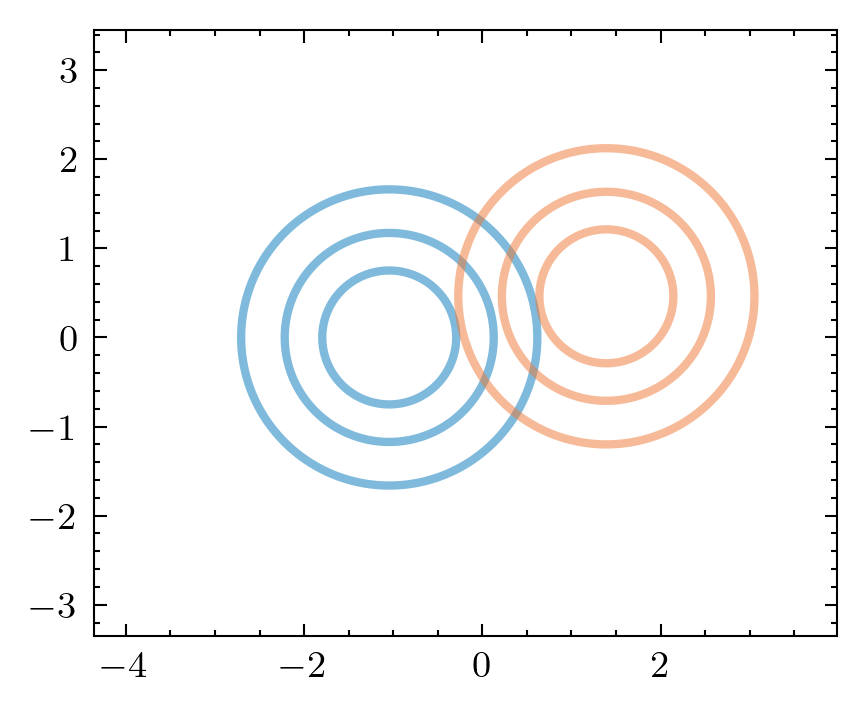

/tmp/ipykernel_5537/1676264114.py:75: UserWarning: linewidths is ignored by contourf
  axis.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(


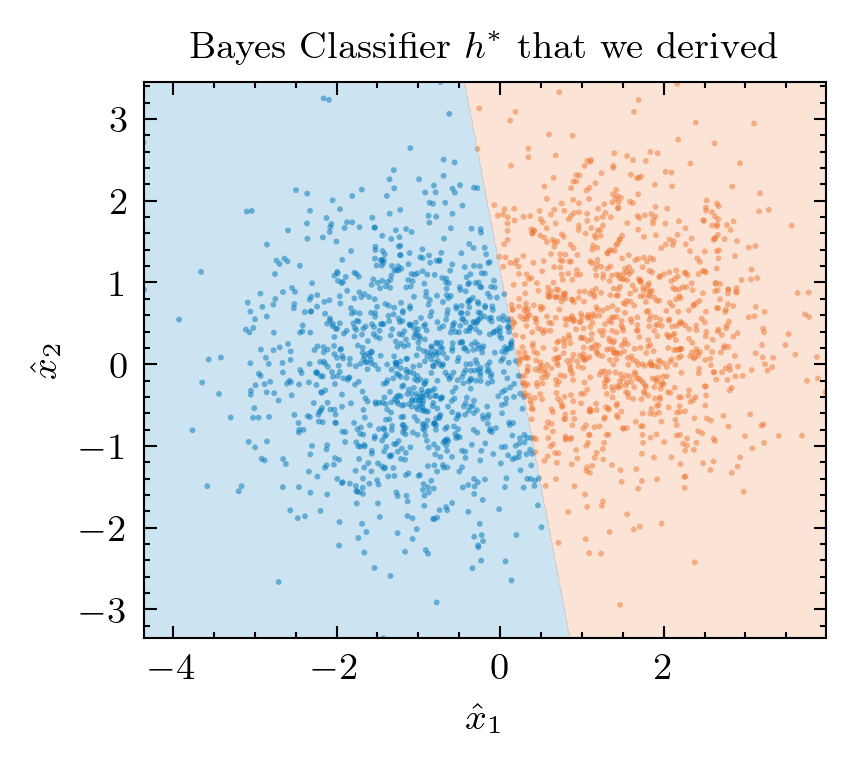

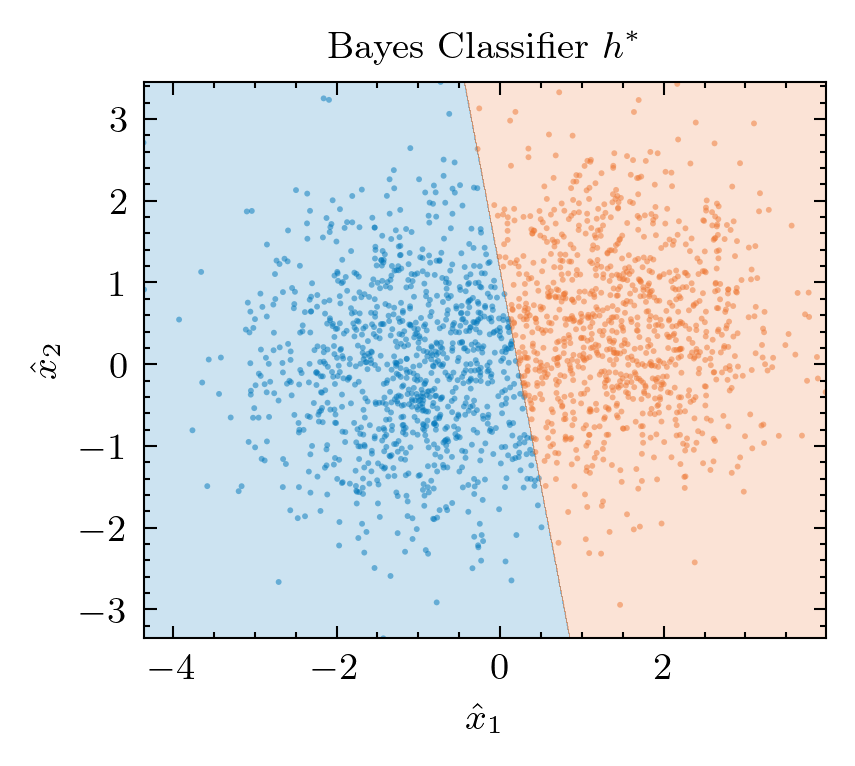

In [47]:
L = np.linalg.cholesky(np.linalg.inv(distributions[0].cov)).T
Xhat = (L @ X.T).T
Xhatmin = np.min(Xhat[:,0])
Xhatmax = np.max(Xhat[:,0])
Yhatmin = np.min(Xhat[:,1])
Yhatmax = np.max(Xhat[:,1])

hat_distributions = []
for distribution, color in zip(distributions, class_colors):
    hat_mu = L @ np.array(distribution.mean)
    distribution = multivariate_normal(mean=hat_mu, cov=np.eye(2))
    hat_distributions.append(distribution)
    visualize_gaussian(distribution=distribution, color=color, levels=3, xmin=Xhatmin, xmax=Xhatmax, ymin=Yhatmin, ymax=Yhatmax, N=1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# Our derivation
gt_probs = [get_gt_probabilities(x, distributions=hat_distributions) for x in Xhat]
y_pred = np.array([np.argmax(probs) for probs in gt_probs])
cs = [class_colors[pred] for pred in y_pred]

plt.scatter(Xhat[:,0], Xhat[:,1], s=2, c=cs, alpha=0.5, linewidths=0)

prior_ratio = 1
hat_mu_diff = hat_distributions[0].mean - hat_distributions[1].mean
const = 2*np.log(prior_ratio) - hat_distributions[0].mean.T @ hat_distributions[0].mean + hat_distributions[1].mean.T @ hat_distributions[1].mean

func = lambda x: (2*hat_mu_diff @ x.T + const) < 0
visualize_decision_boundary(func=func, axis=plt.gca(), xmin=Xhatmin, xmax=Xhatmax, ymin=Yhatmin, ymax=Yhatmax)

plt.xlabel("$\hat x_1$")
plt.ylabel("$\hat x_2$")
plt.title("Bayes Classifier $h^*$ that we derived")
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# "Groundtruth"
plt.scatter(Xhat[:,0], Xhat[:,1], s=2, c=cs, alpha=0.5, linewidths=0)

visualize_optimal_decision_boundary(distributions=hat_distributions, xmin=Xhatmin, xmax=Xhatmax, ymin=Yhatmin, ymax=Yhatmax)

plt.xlabel("$\hat x_1$")
plt.ylabel("$\hat x_2$")
plt.title("Bayes Classifier $h^*$")
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Different Covariance Matrices

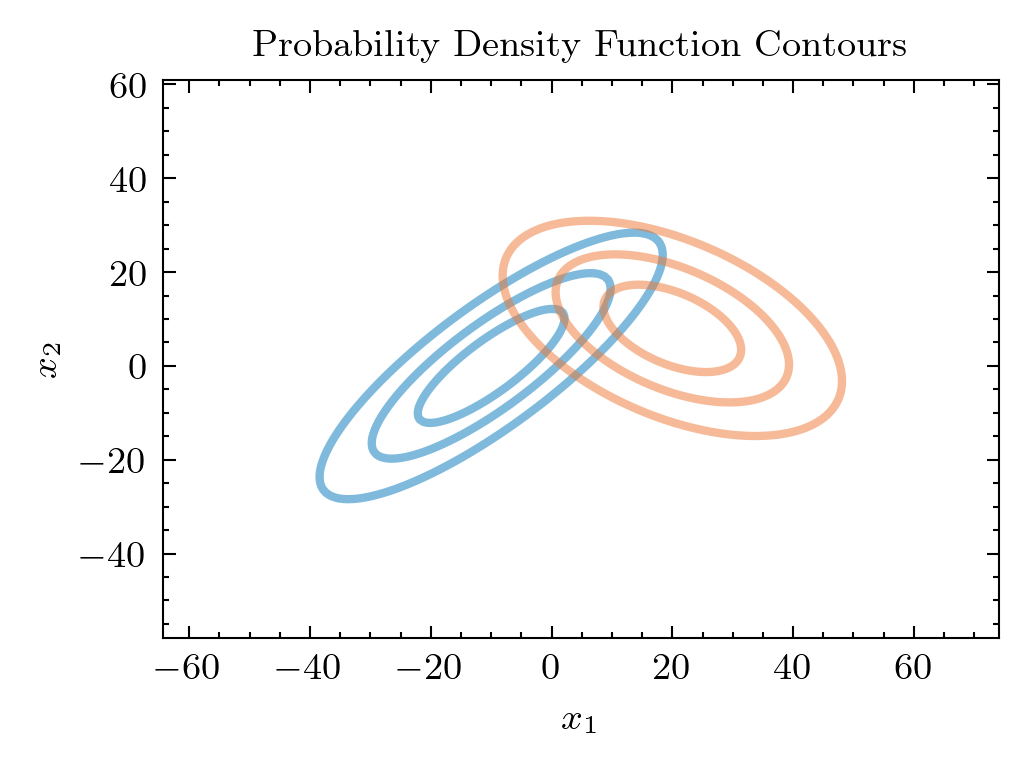

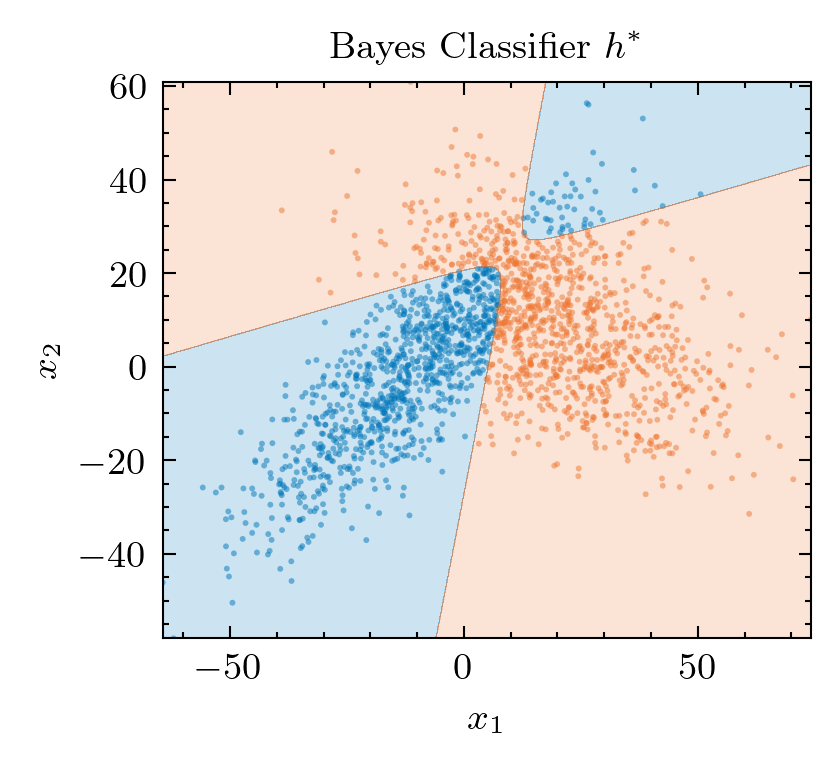

In [49]:
np.random.seed(1)
X, y, distributions = prepare_dataset(N=1000, same_covar=False)

Xmin = np.min(X[:,0])
Xmax = np.max(X[:,0])
Ymin = np.min(X[:,1])
Ymax = np.max(X[:,1])

for distribution, color in zip(distributions, class_colors):
    visualize_gaussian(distribution=distribution, color=color, levels=3, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax)
plt.title("Probability Density Function Contours")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()


gt_probs = [get_gt_probabilities(x, distributions=distributions) for x in X]
y_pred = np.array([np.argmax(probs) for probs in gt_probs])
cs = [class_colors[pred] for pred in y_pred]

plt.scatter(X[:,0], X[:,1], s=2, c=cs, alpha=0.5, linewidths=0)

visualize_optimal_decision_boundary(distributions=distributions, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Bayes Classifier $h^*$")
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()